# Polynomial Regression

I have written a program to perform polynomial regression with L2 regularization.

Recall that polynomial regression learns a function $ h_\theta (x) = \theta_0 + \theta_1x + \theta_2 x^2 + . . . + \theta_d x^d $, where d represents
the polynomial’s highest degree. We can equivalently write this in the form of a linear model with d features
$$ h_\theta (x) = \theta_0 + \theta_1\phi_1(x) + \theta_2\phi_2(x) + . . . + \theta_d\phi_d(x) $$
using the basis expansion that $ \phi_j (x) = x_j $. Notice that, with this basis expansion, we obtain a linear model
where the features are various powers of the single univariate x. We’re still solving a linear regression problem,
but are fitting a polynomial function of the input.

1. See code below for implementation of polyreg with regularization. Function seems to work well, it adds poly terms and standardizes them based off of info from the train set for both the fit and predict methods.

2. I have included a 3x3 grid of plots visualizing the fit of the polyreg function on some randomly generated data of deg 3. Each plot increases the regularization by roughly 3x. As we are estimating a deg 3 poly by a deg 8 model we have quite high variance in our model so increasing the regularization term seems to help significantly in increasing generalization. I only have 11 data points so it can be hard to tell but the larger values seems to be better fits.


In [5]:
from typing import Tuple
import numpy as np
from utils import problem

class PolynomialRegression:
    def __init__(self, degree: int = 1, reg_lambda: float = 1e-8):
        """Constructor
        """
        self.degree: int = degree
        self.reg_lambda: float = reg_lambda
        # Fill in with matrix with the correct shape
        self.weight: np.ndarray = None  # type: ignore
        # You can add additional fields
        self.train_mean: float = None
        self.train_std: float = None
        
    def polyfeatures(X: np.ndarray, degree: int) -> np.ndarray:
        """
        Expands the given X into an (n, degree) array of polynomial features of degree degree.

        Args:
            X (np.ndarray): Array of shape (n, 1).
            degree (int): Positive integer defining maximum power to include.

        Returns:
            np.ndarray: A (n, degree) numpy array, with each row comprising of
                X, X * X, X ** 3, ... up to the degree^th power of X.
                Note that the returned matrix will not include the zero-th power.

        """
        polyfeat = X
        polyfeat.shape = len(X),1
        for i in range(2,degree+1):
            new_col = np.power(X,i)
            polyfeat = np.c_[polyfeat, new_col]
        return(polyfeat)

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Trains the model, and saves learned weight in self.weight

        Args:
            X (np.ndarray): Array of shape (n, 1) with observations.
            y (np.ndarray): Array of shape (n, 1) with targets.

        """ 
        #polynomial X
        X = PolynomialRegression.polyfeatures(X,degree = self.degree)
        
        #standardize X
        self.train_mean = np.mean(X, axis= 0)
        self.train_std = np.std(X, axis = 0)
        X_standard = (X - self.train_mean)/(self.train_std)
        X = X_standard
        
        n = len(X)
        # add 1s column
        X_ = np.c_[np.ones([n, 1]), X]

        n, d = X_.shape
        # remove 1 for the extra column of ones we added to get the original num features
        d = d - 1

        # construct reg matrix
        reg_matrix =  self.reg_lambda* np.eye(d + 1)
        reg_matrix[0, 0] = 0

        # analytical solution (X'X + regMatrix)^-1 X' y
        self.theta = np.linalg.solve(X_.T @ X_ + reg_matrix, X_.T @ y)
        
        

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Use the trained model to predict values for each instance in X.

        Args:
            X (np.ndarray): Array of shape (n, 1) with observations.

        Returns:
            np.ndarray: Array of shape (n, 1) with predictions.
        """
        #poly expand incoming data
        X = PolynomialRegression.polyfeatures(X, degree = self.degree)
        #standardize incoming data
        pred_standard = (X - self.train_mean)/(self.train_std)
        X = pred_standard
        

        # add 1s column
        n = len(X)
        X_ = np.c_[np.ones([n, 1]), X]

        # predict
        return X_.dot(self.theta)


In [6]:
#Need to generate some data as I do not have access to the courses data. Course uses 11 data points.
test_matrix = 0 + 5*np.random.rand(11, 1) #This will give random values from norm distribution N(10,5)
y = test_matrix*3 + 2*np.random.randn(11, 1) #transform them to poly deg 3 and add some error

In [7]:
#little function to calc MSE
def mean_squared_error(a: np.ndarray, b: np.ndarray) -> float:
    """Given two arrays: a and b, both of shape (n, 1) calculate a mean squared error.

    Args:
        a (np.ndarray): Array of shape (n, 1)
        b (np.ndarray): Array of shape (n, 1)

    Returns:
        float: mean squared error between a and b.
    """
    mse = np.sum((a-b)**2/len(a))
    return(mse)

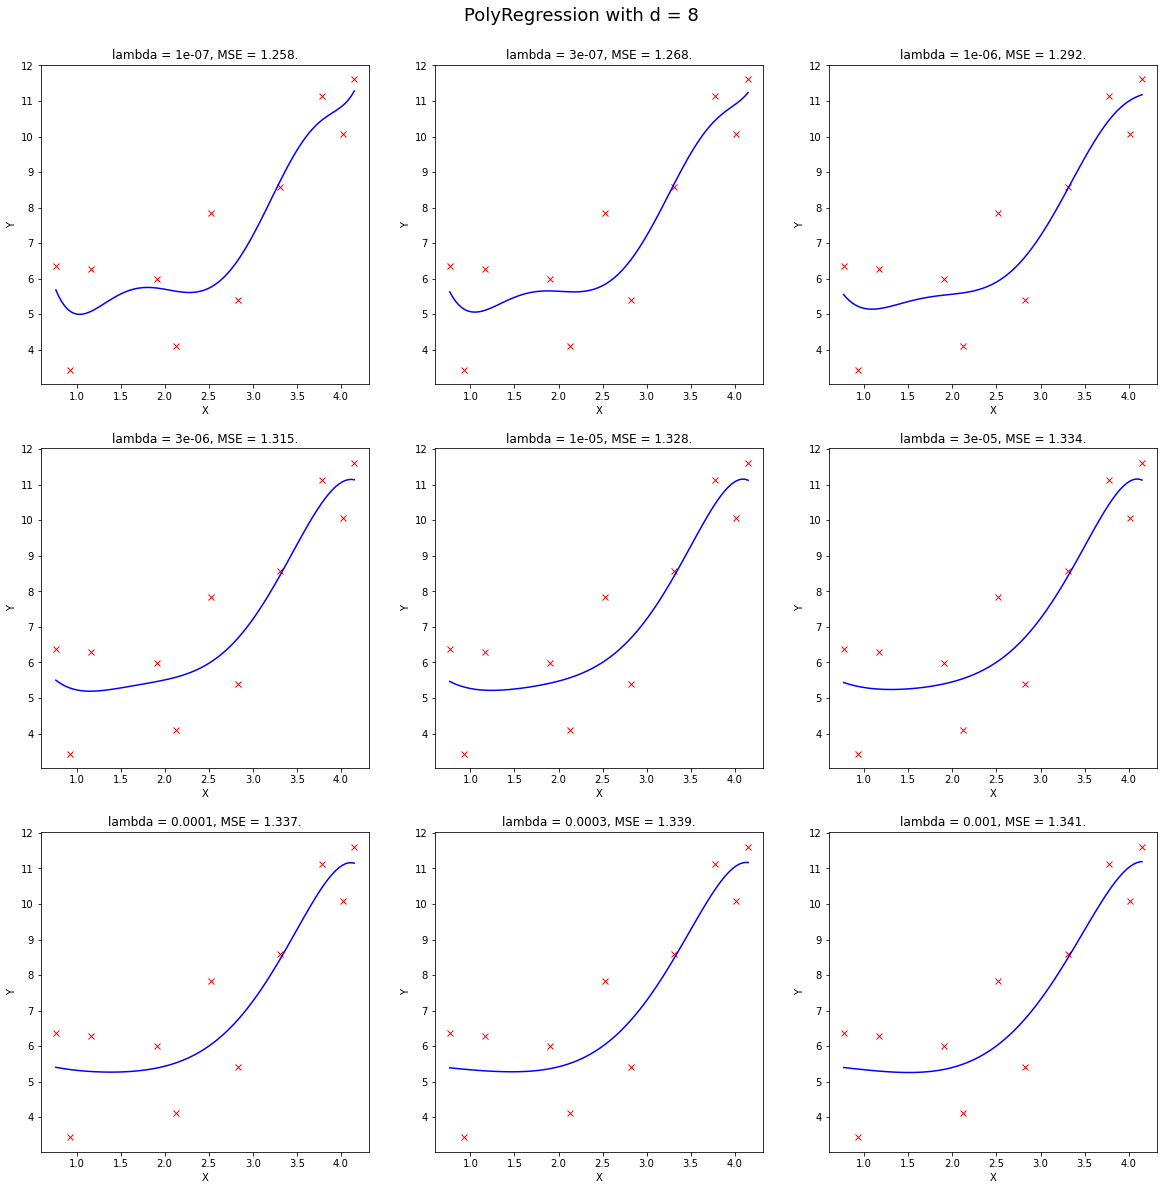

In [8]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
    """
        Main function to test polynomial regression
    """
    X = test_matrix
    y = y

    # regression with degree = d
    d = 8
    #fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
    plt.figure(figsize = (20,20))
    plt.suptitle("PolyRegression with d = {}".format(d), fontsize=18, y = 0.92)
    for n,reg in enumerate([1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5,1e-4,3e-4,1e-3]):
        model = PolynomialRegression(degree=d, reg_lambda=reg)
        model.fit(X, y)
        preds = model.predict(X)

        # output predictions
        xpoints = np.linspace(np.max(X), np.min(X), 100).reshape(-1, 1)
        ypoints = model.predict(xpoints)

        # plot curve
        plt.subplot(3,3,n+1)    
        plt.plot(X, y, "rx")
        plt.title("lambda = {}, MSE = {:.4}.".format(reg,mean_squared_error(preds,y)))
        plt.plot(xpoints, ypoints, "b-")
        plt.xlabel("X")
        plt.ylabel("Y")
    plt.show()


# Learning Curves
In this problem we will examine the bias-variance tradeoff through learning curves. Learning curves provide a valuable mechanism for evaluating the bias-variance tradeoff. We have several learning curves below based off of different degrees of polynomial and values of lambda our regularization parameter. There is a horizontal line at MSE = 1

1. Below are the learning curves for a few values of degree (1,4,8,8,8,8) and lambda (0,1e-6,1e-6,0.1,1,100). We see that the best fits involve the degrees of 4 and 8 with a value of 1e-6 for regularization. The other fits all seem quite poor.

In [9]:
def learningCurve(
    Xtrain: np.ndarray,
    Ytrain: np.ndarray,
    Xtest: np.ndarray,
    Ytest: np.ndarray,
    reg_lambda: float,
    degree: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Compute learning curves.

    Args:
        Xtrain (np.ndarray): Training observations, shape: (n, 1)
        Ytrain (np.ndarray): Training targets, shape: (n, 1)
        Xtest (np.ndarray): Testing observations, shape: (n, 1)
        Ytest (np.ndarray): Testing targets, shape: (n, 1)
        reg_lambda (float): Regularization factor
        degree (int): Polynomial degree

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple containing:
            1. errorTrain -- errorTrain[i] is the training mean squared error using model trained by Xtrain[0:(i+1)]
            2. errorTest -- errorTest[i] is the testing mean squared error using model trained by Xtrain[0:(i+1)]
    """
    n = len(Xtrain)

    errorTrain = np.zeros(n)
    errorTest = np.zeros(n)
    # Fill in errorTrain and errorTest arrays
    for i in range(3,n+1):
        #fit on reduced train set. 
        model = PolynomialRegression(degree= degree, reg_lambda = reg_lambda)
        model.fit(Xtrain[0:i],Ytrain[0:i])
        #generate predicitons
        train_pred = model.predict(Xtrain[0:i])
        test_pred = model.predict(Xtest)
        #calc and store errors
        errorTrain[i-1] = mean_squared_error(train_pred,Ytrain[0:i])
        errorTest[i-1] = mean_squared_error(test_pred,Ytest)
    return(errorTrain, errorTest)
    


In [10]:
#split data hw doesn't specify training and test sizes but plots make it seem like this should be correct. 9-2 split.
x_train = test_matrix[0:9]
x_test = test_matrix[9:]
y_train = y[0:9]
y_test = y[9:]

In [11]:
#j = learningCurve(Xtrain = x_train, Ytrain = y_train, Xtest = x_test, Ytest = y_test, reg_lambda = 0.0001, degree = 8)
# plt.plot(j[0], color = 'blue', marker = 'o', label = 'train')
# plt.plot(j[1],  color = 'red', marker = 'o', label = 'test')
# plt.legend()

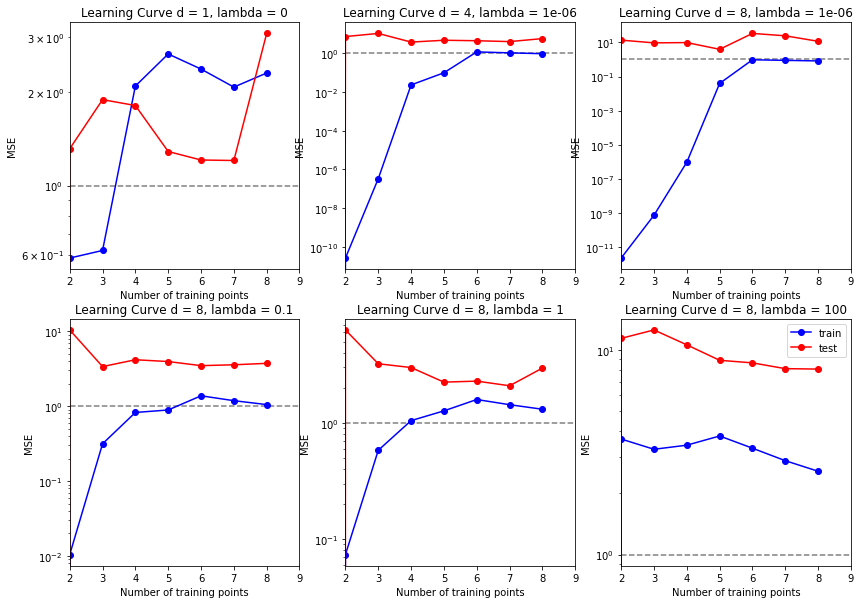

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))
n = 1
for d, reg in zip([1,4,8,8,8,8], [0,1e-6,1e-6,0.1,1,100]):
    j = learningCurve(Xtrain = x_train, Ytrain = y_train, Xtest = x_test, Ytest = y_test, reg_lambda = reg, degree = d)
    plt.subplot(2,3,n)
    plt.title("Learning Curve d = {}, lambda = {}".format(d,reg))
    n+=1
    plt.hlines(1,2,9, linestyle = '--', color = 'gray')
    plt.yscale('log')
    plt.xlim(2,9)
    plt.xlabel("Number of training points")
    plt.ylabel("MSE")
    plt.plot(j[0], color = 'blue', marker = 'o', label = 'train')
    plt.plot(j[1],  color = 'red', marker = 'o', label = 'test')
plt.legend()
plt.show()

# Ridge Regression on MNIST
We will implement a regularized least squares classifier for the MNIST data set. The task is to classify handwritten images of numbers between 0 to 9 We have some results below.

1.  Training and test accuracy both about 86% regardless of regularization. There are pretty much two explanations for this:
    - The bias of the model is extremely high and I am unable to increase variance using essentially a linear model.
    - This is a result of the linebar classifier being unable to properly fit the nonlinearity of the dataset.
2. This should be contrasted with an extremely simple non-parametric model such as KNN which can capture the differences in the images fairly easily. An out of the box sklearn model achieves ~96% accuracy with little to no hyperparameter tuning.

In [10]:
import numpy as np

class RidgeClassifierMulti:
    def __init__(self, reg_lambda: float = 1.0):
        """
        Constructor
        """
        self.reg_lambda: float = reg_lambda # regularization
        self.theta = None #weights
        self.classes = None #classes for prediction as we are multiclass.
        
    def fit(self, X, y):
        """
        Trains the model
        Arguments:
            X is a n-by-d array
            y is an n-by-1 array
        Returns:
            No return value
        """
        #grab the classes for classification
        self.classes = np.unique(y)
        self.theta = []
        #grab shape of input matrix before adding 1s column
        n, d = X.shape
        X_ = np.c_[np.ones([n,1]),X] # add the ones
        reg_matrix = self.reg_lambda * np.eye(d + 1) #regularize, add 1 to d as we have a column of 1's now in X
        reg_matrix[0, 0] = 0 #bias term is not regularized
        
        #Create one for all method of classification for multiclass.
        for c in self.classes:
            y_binary = (y==c) * 1
            theta_c = np.linalg.solve(X_.T @ X_ + reg_matrix, X_.T @ y_binary)
            self.theta.append(theta_c)
        return(self.theta)
            
    
    def predict(self, X):
        """
        Use the trained model to predict values for each instance in X
        Arguments:
            X is a n-by-d numpy array
        Returns:
            an n-by-1 numpy array of the predictions
        """
        n = len(X)
        X_ = np.c_[np.ones([n, 1]), X]
        scores = []
        for weight in self.theta:
            scores.append(X_@weight)
        predictions = np.argmax(scores, axis=0)
        return self.classes[predictions]

In [11]:

import pandas as pd
from tensorflow import keras
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# data = sklearn.datasets.load_digits()
# df = pd.DataFrame(data['data'], columns= data['feature_names'])
# df = pd.concat([df, pd.DataFrame(data['target'], columns = ['target'])], axis = 1)  #dataset has 65 columns, 1 for each of the pixels in the 8x8 grid, as well as a 'target' column w/ the true classification

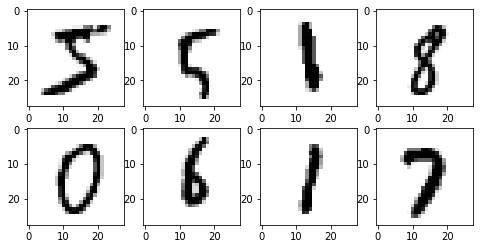

In [12]:
# reshape the data to take a look at an image.
#lets look at a few:
def plot_images(indicies):
    plt.figure(figsize = (8,4))
    for i,num in zip(range(1,len(indicies) +1),indicies):
        first_image = train_X[num]
        plt.subplot(2,4,i)
        plt.imshow(first_image,cmap = 'gray_r')

        
        
indicies = [0, 100, 200,300, 1000, 1100, 1200, 1300]
plot_images(indicies)

In [13]:
#X matrices are in 3d arrays. Matrices of well matrices. Reshape to 60000x(28*28)
train_X = train_X.reshape(60000,784)
test_X = test_X.reshape(10000,784)

In [14]:
# # more testing
# model = RidgeClassifierMulti(reg_lambda = 1)
# thetas = model.fit(train_X, train_y)
# thetas[0]

In [15]:
def ValCurveRidgeClassifier(X_train: np.ndarray,
                    y_train: np.ndarray,
                    X_test: np.ndarray,
                    y_test: np.ndarray,
                    param_range: list):
    """ Compute a validation curve
    Args: 
        X: data capable of being fed into model
        y: target variable capable of being predicted by model
        param_range: list of range for parameter of interest
        
    Returns:
        Nothing, but outputs a nice plot
    """
    
    train_scores = []
    test_scores = []
    
    for param in param_range:
        #fit model w/ param
        model = RidgeClassifierMulti(reg_lambda = param)
        model.fit(X_train,y_train)
        
        #get predictions
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        
        #get errors.
        train_scores.append(np.sum(np.equal(train_preds,y_train))/len(train_preds))
        test_scores.append(np.sum(np.equal(test_preds,y_test))/len(test_preds))
        print("Scores for parameter = {} calculated \n train score: {:.6} \n test score: {:.6}".format(
            param,np.sum(np.equal(train_preds,y_train))/len(train_preds), np.sum(np.equal(test_preds,y_test))/len(test_preds)) )
    
    plt.plot(param_range, train_scores, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.plot(param_range, test_scores, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
    
    plt.grid()
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.xlabel('Parameter C')
    plt.ylabel('Accuracy')
    plt.ylim([0.8, 1.03])
    plt.show()    
        

Scores for parameter = 1000000.0 calculated 
 train score: 0.857067 
 test score: 0.8613
Scores for parameter = 3000000.0 calculated 
 train score: 0.857133 
 test score: 0.8619
Scores for parameter = 10000000.0 calculated 
 train score: 0.857467 
 test score: 0.8623
Scores for parameter = 30000000.0 calculated 
 train score: 0.857333 
 test score: 0.8644
Scores for parameter = 100000000.0 calculated 
 train score: 0.85805 
 test score: 0.864
Scores for parameter = 300000000.0 calculated 
 train score: 0.854567 
 test score: 0.8634
Scores for parameter = 1000000000.0 calculated 
 train score: 0.844433 
 test score: 0.8527


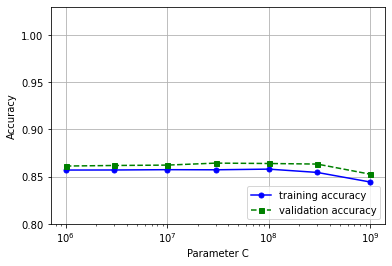

In [16]:
#This may take a while.
params =  [1e6, 3e6, 1e7, 3e7, 1e8, 3e8, 1e9]

ValCurveRidgeClassifier(X_train = train_X, y_train = train_y, X_test = test_X, y_test = test_y, param_range = params)

In [17]:
#Model seems kinda bad so let me just check KNN just incase something is weird
from sklearn.neighbors import KNeighborsClassifier

model2 =  KNeighborsClassifier()
model2.fit(train_X,train_y)

#get predictions
train_preds = model2.predict(train_X)
test_preds = model2.predict(test_X)

#get errors.
print((np.sum(np.equal(train_preds,train_y))/len(train_preds)))
print((np.sum(np.equal(test_preds,test_y))/len(test_preds)))

0.9819166666666667
0.9688
